# Projeto PAMAP2

O objetivo do projeto é desenvolver modelos que permitam classificar quanto à atividade dados com a mesma estrutura aos obtidos no dataset de referência ( [PAMAP2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) ). Apenas serão consideradas as atividades 4, 5, 6, 7 e 24 (5 atividades de intensidade do membro inferior (?)). Estas correspondem, respetivamente, a 'Walking', 'Running', 'Cycling', 'Nordic Walking', e 'Rope Jumping'.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import sklearn as sk
from sklearn.model_selection import train_test_split

In [2]:
dataCol_o = pd.read_csv('data\data_df.csv')
dataCol_o.shape

(1942872, 43)

In [3]:
dataCol_o.head()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1


In [4]:
#Para experimentar o codigo: sample de 100k. Correr com os dados todos no pc
dataCol_o= dataCol_o.sample(n= 350000, random_state= 1)

In [5]:
dataCol= dataCol_o.sample(frac= 0.8, random_state= 1)
test_data= dataCol_o.drop(dataCol.index)

dataCol.shape[0]+test_data.shape[0]== dataCol_o.shape[0]

True

In [6]:
act_n= [4, 5, 6, 7, 24]

In [7]:
test_data.drop(['timestamp', 'subject_id'], axis= 1, inplace=True)
test_data.reset_index(inplace= True)
test_data.drop(['index'], axis= 1, inplace= True)
test_data= test_data.loc[test_data['activityID'].isin(act_n)]
test_data['activityID'].value_counts()

4     8643
7     6981
6     5868
5     3550
24    1766
Name: activityID, dtype: int64

In [8]:
features_test_data= test_data.drop(['activityID'], axis= 1, inplace=False)
true_labels_test_data= test_data['activityID']

In [9]:
act_data= dataCol.loc[dataCol['activityID'].isin(act_n)]
act_data['activityID'].value_counts()

4     34069
7     26882
6     23832
5     14119
24     7138
Name: activityID, dtype: int64

<Axes: xlabel='activityID'>

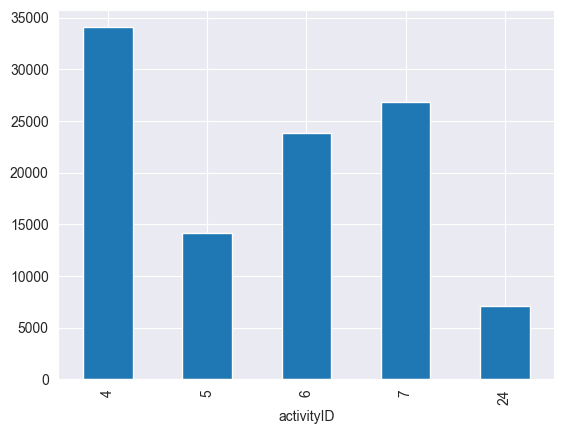

In [10]:
act_data.groupby('activityID').size().plot(kind='bar',
                                       y = 'activityID',
                                       label = "Type",)

Como as diferentes classes têm counts bastante diferentes irão ser aplicadas técnicas que permitam equilibrar as diferentes classes do dataset

## Downsampling

In [11]:
from sklearn.utils import resample

act_downsample= []
for i in range(len(act_n)):
    act_downsample.append(resample(act_data.loc[act_data['activityID']== act_n[i]],
                 replace=True,
                 n_samples= min(act_data['activityID'].value_counts()),
                 random_state=1))

In [12]:
data_downsampled_df= pd.concat(act_downsample).drop(['timestamp', 'subject_id'], axis= 1)
data_downsampled_df.reset_index(inplace= True)
data_downsampled_df.drop(['index'], axis=1, inplace= True)

In [13]:
train_val_df= data_downsampled_df.sample(frac= 0.8, random_state= 1)
test_df= data_downsampled_df.drop(train_val_df.index)

train_val_df.shape[0]+test_df.shape[0]== data_downsampled_df.shape[0] #check if the split has lost any rows. If true no rows were lost. If False some rows were lost in the split

True

In [14]:
train_val_df.shape, test_df.shape

((28552, 41), (7138, 41))

In [15]:
train_val_df.to_csv('train_val_df_downsampled.csv', index=False)
test_df.to_csv('test_df_downsampled.csv', index=False)

In [16]:
train_val_df= pd.read_csv('train_val_df_downsampled.csv')
test_df= pd.read_csv('test_df_downsampled.csv')

Separar as features e as labels para as dfs de treino/validação e teste

In [17]:
features_tv_df= train_val_df.drop(['activityID'], axis= 1, inplace=False)

features_ts_df= test_df.drop(['activityID'], axis= 1, inplace=False)
true_labels_ts= test_df['activityID']
features_tv_df.shape, features_ts_df.shape, true_labels_ts.shape

((28552, 40), (7138, 40), (7138,))

Para utilizar a loss function 'Categorical Crossentropy' é necessário que as target labels sejam dadas no formato one-hot

In [18]:
from sklearn.preprocessing import LabelBinarizer

targets_onehot_tv = LabelBinarizer().fit_transform(train_val_df.activityID)
targets_onehot_tv.shape

(28552, 5)

Dividir o Train/Validation dataset

In [19]:
x_train, x_val, y_train, y_val = train_test_split(features_tv_df, targets_onehot_tv, test_size=0.2, random_state=1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((22841, 40), (5711, 40), (22841, 5), (5711, 5))

 Vão ser utilizados modelos com arquiteturas iguais aos do projeto A

| **Scaler/Modelo** 	| **Simples/GG** 	 | **Grande** 	|
|-------------------	|------------------|------------	|
| **Nada**          	| NS          	    | NG         	|
| **MinMax**        	| MS        	      | MG         	|

Aplicar Min Max Scaling aos dados

In [24]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#apply scaling to all columns except subject and activity
scalerM = MinMaxScaler()
x_train_s = x_train.copy()
x_val_s = x_val.copy()
x_test_s= features_ts_df.copy()
x_test_data= features_test_data.copy()

x_train_s = scalerM.fit_transform(x_train_s)
x_val_s = scalerM.transform(x_val_s)
x_test_s= scalerM.transform(x_test_s)
x_test_data= scalerM.transform(x_test_data)
pd.DataFrame(x_train_s).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,...,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000
mean,0.468841,0.616437,0.731118,0.332205,0.615590,0.669595,0.533600,0.643575,0.463590,0.494042,...,0.453950,0.516191,0.510667,0.605162,0.512782,0.449523,0.492434,0.625484,0.595203,0.505452
std,0.204823,0.213704,0.072249,0.053369,0.045780,0.093752,0.085983,0.053955,0.040897,0.085623,...,0.024756,0.079386,0.082597,0.050856,0.058730,0.074281,0.127866,0.067621,0.113825,0.079225
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.330645,0.478261,0.693344,0.312104,0.596029,0.620740,0.500186,0.619974,0.448796,0.459511,...,0.447609,0.475224,0.482137,0.589601,0.483798,0.422293,0.415049,0.592595,0.511759,0.451838
50%,0.403226,0.590062,0.731246,0.327855,0.615904,0.670012,0.526936,0.644321,0.461970,0.487733,...,0.455159,0.504915,0.503101,0.609028,0.512144,0.455491,0.483965,0.623655,0.585947,0.510240
75%,0.637097,0.801242,0.773619,0.347023,0.641924,0.725123,0.559831,0.675952,0.476874,0.523718,...,0.462136,0.551180,0.534900,0.626375,0.540268,0.487003,0.550597,0.655305,0.683035,0.566698
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
n_features = features_tv_df.shape[1]
n_classes = targets_onehot_tv.shape[1]
n_features, n_classes

(40, 5)

In [27]:
pd.DataFrame(x_test_s).to_csv('scaled_test_features_downsampled.csv', index= False)
true_labels_ts.to_csv('true_labels_ts_downsampled.csv', index= False)
features_ts_df.to_csv('features_ts_df_downsampled.csv', index= False)
features_test_data.to_csv('features_test_data.csv', index= False)
true_labels_test_data.to_csv('true_labels_test_data.csv', index= False)
pd.DataFrame(x_test_data).to_csv('scaled_features_test_data_ds.csv', index= False)

In [20]:
from tensorflow import keras
tf.keras.backend.clear_session()

In [33]:
def compile_fit(model, x_train, y_train, x_val, y_val, epochs, batch_s= 128):
    model.compile(optimizer= 'adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])
    history = model.fit(x_train, y_train, batch_size= batch_s, epochs= epochs, validation_data= (x_val, y_val))

    return history

In [34]:
model_history= {}

In [37]:
NS = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['NS']= compile_fit(NS, x_train, y_train, x_val, y_val, 20, 128)

Epoch 1/20
161/161 [==============================] - 2s 9ms/step - loss: 1.2244 - categorical_accuracy: 0.6668 - val_loss: 0.4674 - val_categorical_accuracy: 0.8347
Epoch 2/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3738 - categorical_accuracy: 0.8716 - val_loss: 0.3342 - val_categorical_accuracy: 0.8864
Epoch 3/20
161/161 [==============================] - 1s 6ms/step - loss: 0.2810 - categorical_accuracy: 0.9084 - val_loss: 0.2699 - val_categorical_accuracy: 0.9067
Epoch 4/20
161/161 [==============================] - 1s 6ms/step - loss: 0.2184 - categorical_accuracy: 0.9289 - val_loss: 0.2113 - val_categorical_accuracy: 0.9305
Epoch 5/20
161/161 [==============================] - 1s 6ms/step - loss: 0.1868 - categorical_accuracy: 0.9385 - val_loss: 0.2014 - val_categorical_accuracy: 0.9329
Epoch 6/20
161/161 [==============================] - 1s 6ms/step - loss: 0.1533 - categorical_accuracy: 0.9498 - val_loss: 0.1586 - val_categorical_accuracy: 0.9452
Epoc

In [39]:
NG= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['NG']= compile_fit(NG, x_train, y_train, x_val, y_val, 20, 128)

Epoch 1/20
161/161 [==============================] - 2s 10ms/step - loss: 0.5735 - categorical_accuracy: 0.8227 - val_loss: 0.2279 - val_categorical_accuracy: 0.9200
Epoch 2/20
161/161 [==============================] - 1s 8ms/step - loss: 0.1692 - categorical_accuracy: 0.9389 - val_loss: 0.1459 - val_categorical_accuracy: 0.9479
Epoch 3/20
161/161 [==============================] - 1s 8ms/step - loss: 0.1185 - categorical_accuracy: 0.9577 - val_loss: 0.1147 - val_categorical_accuracy: 0.9616
Epoch 4/20
161/161 [==============================] - 1s 7ms/step - loss: 0.0879 - categorical_accuracy: 0.9689 - val_loss: 0.1152 - val_categorical_accuracy: 0.9571
Epoch 5/20
161/161 [==============================] - 1s 7ms/step - loss: 0.0702 - categorical_accuracy: 0.9745 - val_loss: 0.0729 - val_categorical_accuracy: 0.9754
Epoch 6/20
161/161 [==============================] - 1s 8ms/step - loss: 0.0578 - categorical_accuracy: 0.9790 - val_loss: 0.1093 - val_categorical_accuracy: 0.9612
Epo

In [42]:
MG = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['MG']= compile_fit(MG, x_train_s, y_train, x_val_s, y_val, 20, 128)

Epoch 1/20
161/161 [==============================] - 2s 8ms/step - loss: 0.7651 - categorical_accuracy: 0.6717 - val_loss: 0.7295 - val_categorical_accuracy: 0.6821
Epoch 2/20
161/161 [==============================] - 1s 5ms/step - loss: 0.4024 - categorical_accuracy: 0.8519 - val_loss: 0.2846 - val_categorical_accuracy: 0.8999
Epoch 3/20
161/161 [==============================] - 1s 7ms/step - loss: 0.2516 - categorical_accuracy: 0.9144 - val_loss: 0.3143 - val_categorical_accuracy: 0.8802
Epoch 4/20
161/161 [==============================] - 1s 7ms/step - loss: 0.1891 - categorical_accuracy: 0.9363 - val_loss: 0.1676 - val_categorical_accuracy: 0.9387
Epoch 5/20
161/161 [==============================] - 1s 7ms/step - loss: 0.1448 - categorical_accuracy: 0.9489 - val_loss: 0.1773 - val_categorical_accuracy: 0.9329
Epoch 6/20
161/161 [==============================] - 1s 8ms/step - loss: 0.1111 - categorical_accuracy: 0.9624 - val_loss: 0.3395 - val_categorical_accuracy: 0.8667
Epoc

In [43]:
MS= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['MS']= compile_fit(MS, x_train_s, y_train, x_val_s, y_val, 20, 128)

Epoch 1/20
161/161 [==============================] - 2s 8ms/step - loss: 1.1336 - categorical_accuracy: 0.5506 - val_loss: 0.8740 - val_categorical_accuracy: 0.6062
Epoch 2/20
161/161 [==============================] - 1s 6ms/step - loss: 0.7032 - categorical_accuracy: 0.7295 - val_loss: 0.6235 - val_categorical_accuracy: 0.7567
Epoch 3/20
161/161 [==============================] - 1s 6ms/step - loss: 0.5449 - categorical_accuracy: 0.7977 - val_loss: 0.4926 - val_categorical_accuracy: 0.8250
Epoch 4/20
161/161 [==============================] - 1s 6ms/step - loss: 0.4522 - categorical_accuracy: 0.8430 - val_loss: 0.4432 - val_categorical_accuracy: 0.8373
Epoch 5/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3955 - categorical_accuracy: 0.8637 - val_loss: 0.4066 - val_categorical_accuracy: 0.8412
Epoch 6/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3593 - categorical_accuracy: 0.8766 - val_loss: 0.3493 - val_categorical_accuracy: 0.8802
Epoc

In [44]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display

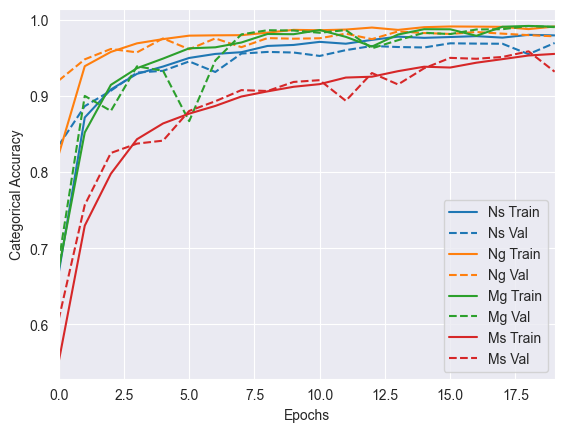

In [45]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'categorical_accuracy')
plotter.plot(model_history)


In [46]:
NS.save('Models Projeto B/NS_ds')
NG.save('Models Projeto B/NG_ds')
MG.save('Models Projeto B/MG_ds')
MS.save('Models Projeto B/MS_ds')

INFO:tensorflow:Assets written to: Models Projeto B/NS_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/NG_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/MG_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/MS_ds\assets
